In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks, welch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Model Accuracies

The accuracies of the trained models are as follows:

- **Neural Network**: 94%, test_accuracy: 93.7%
- **XGBoost Classifier**: 92.6%
- **Support Vector Machine (SVM)**: 86%
- **Random Forest**: 96.03%

In [2]:
df = pd.read_csv('Impact-events-dataset/merged_dataset.csv', delimiter=';')
print(df.head())
df.drop(columns = ['sampleNo', 'typeofimpact', 'ID'], inplace = True)
print(df.head())
print(len(df))

   sensorA  sensorB  sensorC  sensorD  sampleNo typeofimpact position     x  \
0     1788     1796     1789     1783         0         ball      4_4  22.3   
1     1791     1789     1793     1792         1         ball      4_4  22.3   
2     1784     1796     1802     1783         2         ball      4_4  22.3   
3     1792     1795     1778     1789         3         ball      4_4  22.3   
4     1801     1777     1800     1791         4         ball      4_4  22.3   

      y  height    ID  experimentNo  
0  23.7    12.5  85.0             1  
1  23.7    12.5  85.0             1  
2  23.7    12.5  85.0             1  
3  23.7    12.5  85.0             1  
4  23.7    12.5  85.0             1  
   sensorA  sensorB  sensorC  sensorD position     x     y  height  \
0     1788     1796     1789     1783      4_4  22.3  23.7    12.5   
1     1791     1789     1793     1792      4_4  22.3  23.7    12.5   
2     1784     1796     1802     1783      4_4  22.3  23.7    12.5   
3     1792     17

In [3]:
positions_to_remove = ['1_1', '1_5', '5_1', '5_5']

df1 = df[~df['position'].isin(positions_to_remove)]

print(df1.head())
print(len(df1))

   sensorA  sensorB  sensorC  sensorD position     x     y  height  \
0     1788     1796     1789     1783      4_4  22.3  23.7    12.5   
1     1791     1789     1793     1792      4_4  22.3  23.7    12.5   
2     1784     1796     1802     1783      4_4  22.3  23.7    12.5   
3     1792     1795     1778     1789      4_4  22.3  23.7    12.5   
4     1801     1777     1800     1791      4_4  22.3  23.7    12.5   

   experimentNo  
0             1  
1             1  
2             1  
3             1  
4             1  
3855000


In [4]:
sensor_columns = ['sensorA', 'sensorB', 'sensorC', 'sensorD']
print(df[sensor_columns].describe())

            sensorA       sensorB       sensorC       sensorD
count  3.855000e+06  3.855000e+06  3.855000e+06  3.855000e+06
mean   1.790466e+03  1.794333e+03  1.793815e+03  1.792419e+03
std    8.682298e+01  1.015747e+02  8.367260e+01  1.005864e+02
min   -3.570000e+02 -3.850000e+02 -3.520000e+02 -3.710000e+02
25%    1.775000e+03  1.781000e+03  1.780000e+03  1.782000e+03
50%    1.796000e+03  1.799000e+03  1.799000e+03  1.797000e+03
75%    1.810000e+03  1.812000e+03  1.812000e+03  1.809000e+03
max    4.048000e+03  4.057000e+03  4.040000e+03  4.055000e+03


Get the inside points.

In [5]:
def extract_features(group):
    features = {}
    sensors = ['sensorA', 'sensorB', 'sensorC', 'sensorD']
    
    for sensor in sensors:
        data = group[sensor]
        features[f'{sensor}_mean'] = data.mean()
        features[f'{sensor}_std'] = data.std()
        features[f'{sensor}_min'] = data.min()
        features[f'{sensor}_max'] = data.max()
        features[f'{sensor}_skew'] = skew(data)
        features[f'{sensor}_kurtosis'] = kurtosis(data)
        features[f'{sensor}_energy'] = np.sum(data**2)
    
    features['height'] = group['height'].iloc[0]
    
    features['position'] = group['position'].iloc[0]
    
    return pd.Series(features)

features_df = df.groupby('experimentNo').apply(extract_features).reset_index(drop=True)

X = features_df.drop(columns=['position'])  
y = features_df['position']               

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)


Training Features Shape: (539, 29)
Testing Features Shape: (232, 29)
Training Target Shape: (539,)
Testing Target Shape: (232,)


C:\Users\kunal\AppData\Local\Temp\ipykernel_68384\1807712365.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = df.groupby('experimentNo').apply(extract_features).reset_index(drop=True)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

n_estimators = 30
max_depth = 8
max_samples = 280  
n_iterations = 10

# To store results
accuracies = []
confusion_matrices = []

for i in range(n_iterations):
    print(f"Iteration {i+1}:")
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_samples=max_samples,  
        random_state=i  
    )
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {acc:.4f}\n")

average_accuracy = np.mean(accuracies)

print(f"Accuracies for each iteration: {accuracies}")
print(f"Average accuracy over {n_iterations} iterations: {average_accuracy:.4f}")


Iteration 1:
Confusion Matrix:
[[ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  1 12  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  1  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0  0  0 10  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 1

In [5]:
sensor_positions = {
    'A': (33,30),
    'B': (33, 287),
    'C': (287,287),
    'D': (287,30),
}

def calculate_distances(sensor_positions):
    distances = {}
    keys = list(sensor_positions.keys())
    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            key1, key2 = keys[i], keys[j]
            pos1, pos2 = sensor_positions[key1], sensor_positions[key2]
            distance = np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
            distances[f'{key1}_{key2}_dist'] = distance
    return distances

distances = calculate_distances(sensor_positions)
print(distances)

{'A_B_dist': 257.0, 'A_C_dist': 361.3377921004112, 'A_D_dist': 254.0, 'B_C_dist': 254.0, 'B_D_dist': 361.3377921004112, 'C_D_dist': 257.0}


In [10]:


def extract_features(group, distances):
    features = {}
    sensors = ['sensorA', 'sensorB', 'sensorC', 'sensorD']
    
    for sensor in sensors:
        data = group[sensor]
        
        features[f'{sensor}_mean'] = data.mean()
        features[f'{sensor}_std'] = data.std()
        features[f'{sensor}_min'] = data.min()
        features[f'{sensor}_max'] = data.max()
        features[f'{sensor}_range'] = data.max() - data.min()
        features[f'{sensor}_skew'] = skew(data)
        features[f'{sensor}_kurtosis'] = kurtosis(data)
        
    
    features['height'] = group['height'].iloc[0]
    
    #for key, value in distances.items():
    #    features[key] = value
    
    features['position'] = group['position'].iloc[0]
    
    return pd.Series(features)

features_df = df.groupby('experimentNo').apply(extract_features, distances=distances).reset_index(drop=True)

X = features_df.drop(columns=['position'])
y = features_df['position']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


C:\Users\kunal\AppData\Local\Temp\ipykernel_27892\1539558969.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = df.groupby('experimentNo').apply(extract_features, distances=distances).reset_index(drop=True)


In [7]:
X_train.shape

(539, 29)

In [65]:
n_estimators = 50
max_depth = 10
max_samples = 280  
n_iterations = 10

accuracies = []
confusion_matrices = []

for i in range(n_iterations):
    print(f"Iteration {i+1}:")
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_samples=max_samples,  
        random_state=i  
    )
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {acc:.4f}\n")

average_accuracy = np.mean(accuracies)

#print(f"Accuracies for each iteration: {accuracies}")
print(f"Average accuracy over {n_iterations} iterations: {average_accuracy:.4f}")


Iteration 1:
Confusion Matrix:
[[ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0  0  0 11  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 1

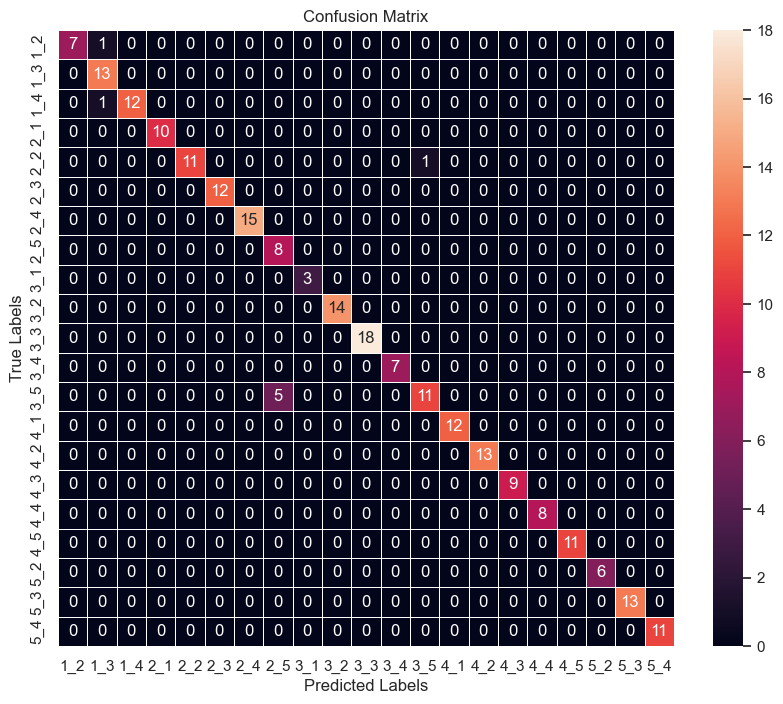

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(10, 8))
    sns.set(style="dark")
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', cbar=True, 
                xticklabels=labels, yticklabels=labels, linewidths=0.5, square=True)
    
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


y_pred = rf.predict(X_test)

unique_labels = sorted(y.unique())
plot_confusion_matrix(y_test, y_pred, labels=unique_labels)


In [ ]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions, target_names=label_encoder.classes_))



svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions, target_names=label_encoder.classes_))

k:\TUD\WHK2\PINNs\.conda\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:09:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9267241379310345
XGBoost Classification Report:
              precision    recall  f1-score   support

         1_2       1.00      1.00      1.00         8
         1_3       1.00      0.92      0.96        13
         1_4       0.93      1.00      0.96        13
         2_1       0.90      0.90      0.90        10
         2_2       1.00      0.83      0.91        12
         2_3       0.86      1.00      0.92        12
         2_4       0.83      1.00      0.91        15
         2_5       0.89      1.00      0.94         8
         3_1       0.60      1.00      0.75         3
         3_2       1.00      0.86      0.92        14
         3_3       0.89      0.94      0.92        18
         3_4       0.88      1.00      0.93         7
         3_5       0.87      0.81      0.84        16
         4_1       1.00      0.92      0.96        12
         4_2       1.00      0.77      0.87        13
         4_3       1.00      1.00      1.00         9
         4_4 

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


num_classes = len(set(y))
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  
    Dense(64, activation='relu'),  
    Dense(32, activation='relu'),                                        
    Dense(num_classes, activation='softmax')                  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_one_hot, epochs=500, batch_size=32, validation_split=0.2, verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred_labels))


Epoch 1/500


k:\TUD\WHK2\PINNs\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0727 - loss: 3.0157 - val_accuracy: 0.1852 - val_loss: 2.8692
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2770 - loss: 2.7330 - val_accuracy: 0.2685 - val_loss: 2.6831
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3472 - loss: 2.4560 - val_accuracy: 0.3056 - val_loss: 2.5027
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4658 - loss: 2.1625 - val_accuracy: 0.3981 - val_loss: 2.2854
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5464 - loss: 1.8836 - val_accuracy: 0.4074 - val_loss: 2.0438
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6926 - loss: 1.5146 - val_accuracy: 0.5000 - val_loss: 1.7709
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7343 - loss: 1.3326 - val_accuracy: 0.5370 - val_loss: 1.5140
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7460 - loss: 1.0983 - val_accuracy: 0.5463 - val_loss: 1.

# Model Accuracies

The accuracies of the trained models are as follows:

- **Neural Network**: 94%, test_accuracy: 93.7%
- **XGBoost Classifier**: 92.6%
- **Support Vector Machine (SVM)**: 86%
- **Random Forest**: 96.03%
